<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic9/HFST9_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

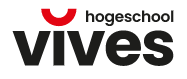<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# 9. EXTRA: Object Detection

## Wat?

**Object detection** is een computer vision taak waarbij het neurale netwerk niet alleen moet voorspellen wat voor soort objecten in een image voorkomen, maar ook waar die objecten zich bevinden.

## Hoe?

Er bestaan methoden die geen gebruik maken van neurale netwerken, zoals de *Histogram of Oriented Gradients* (HOG) methode om de nodige features te definiëren, waarna een classificatie wordt uitgevoerd, bijv. met een Support Vector Machine (SVM). Maar zoals we weten hebben neurale netwerken het voordeel dat ze zowel de features kunnen detecteren als de regressie en/of classificatie kunnen uitvoeren.

Net als bij andere computer vision taken zijn het vooral **Convolutional Neural Networks** (CNNs) die worden toegepast bij object detection. Bekende modellen zijn:

- Region-based CNNs (R-CNNs)
- YOLO (You Only Look Once)
- Retina-Net
- RefineDet
- EfficientDet
- ...



## De Bounding Box

Een cruciaal concept bij object detection is de **bounding box**, een rechthoek rondom het object dat moet worden gedetecteerd. Adhv die rechthoek wordt de positie van het object in de image aangegeven. Dat kan met 4 getallen, bijv.
- de x en y coördinaten van de linker benedenhoek en de rechter bovenhoek,
- de x en y coördinaat van de linker benedenhoek, de breedte en de hoogte,
- de x en y coördinaat van het middelpunt, de breedte en de hoogte,
- ...

De figuur hieronder illustreert het principe:

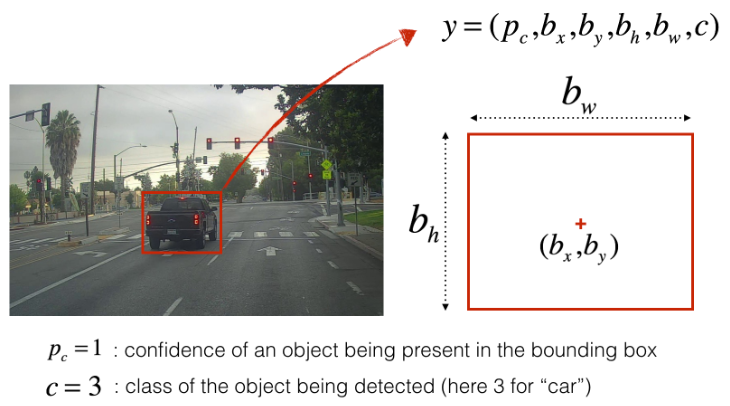

De bounding box wordt dus weergegeven door de coördinaat van het middelpunt $(b_x, b_y)$, de breedte $b_w$ en de hoogte $b_h$. Het neurale netwerk zal dus die 4 getallen moeten voorspellen. Dat is een regressieprobleem, ook wel **bounding box regression** genaamd.

Maar dat is natuurlijk niet de enige output die het model moet voorspellen. Het model moet ook het object classificeren. Op de figuur is dat de variabele $c$ die de klasse van het object aangeeft, in dit geval "car". Tenslotte is er ook nog de kans $p_c$ dat het object aanwezig is in de bounding box. In dit geval krijgen we dus 6 outputs.

## Intersection over Union

Een maat om te bepalen hoe goed de voorspelde bounding box overeenkomt met de gegeven bounding box is de **Intersection over Union** (IoU). De figuur hieronder legt mooi uit hoe die metriek wordt berekend:

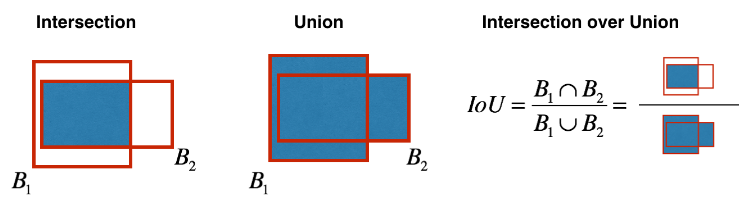

Hieronder zie je een specifiek voorbeeld van een gegeven bounding box $B_1$ (blauw) met een oppervlakte van 25 eenheden en een voorspelde bounding box $B_2$ (rood) met dezelfde oppervlakte waarbij de overlap gelijk is aan 16 eenheden. Die overlap is de "intersection" (of doorsnede in het Nederlands). De "union" (unie in het Nederlands) is 25 + 9 eenheden. De IoU is dus 16 gedeeld door 34, wat afgerond gelijk is aan 0.47.

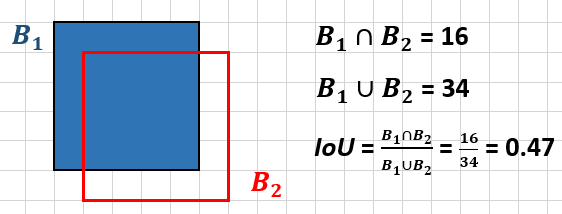

Het is duidelijk dat de IoU gelijk is aan 0 als er geen overlap is, en gelijk is aan 1 als de twee rechthoeken volledig samenvallen.

## Eenvoudig voorbeeldje

Om "bounding box regression" adhv een neuraal netwerk te illustreren, nemen we het eerste voorbeeldje van deze [blog](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491).

In dat voorbeeld worden 50 000 zwart-wit images gegenereerd van 8 op 8 pixels met één willekeurige rechthoek op getekend die minimum 1 en maximum 4 pixels breed en hoog is. De positie van de rechthoek is uiteraard ook willekeurig.

Deze images zijn de input. De output bestaat uit de bounding boxes van de rechthoeken die hier wordt bepaald door de coördinaat `(x, y)` van de linker benedenhoek, de breedte `w`, en de hoogte `h`. Omdat het allemaal zwarte rechthoeken zijn, moeten we de objecten niet classificeren. We bepalen ook niet de kans dat de rechthoek in de voorspelde bounding box aanwezig is, dus hebben we in dit geval slechts 4 outputvariabelen.

Laten we eerst de dataset creëren.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Create images with random rectangles and bounding boxes.

num_imgs = 50_000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

imgs = np.zeros((num_imgs, img_size, img_size))  # input (set background to 0)
bboxes = np.zeros((num_imgs, num_objects, 4))  # output

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, y:y+h, x:x+w] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

Ter illustratie plotten we het eerste voorbeeld in de dataset:

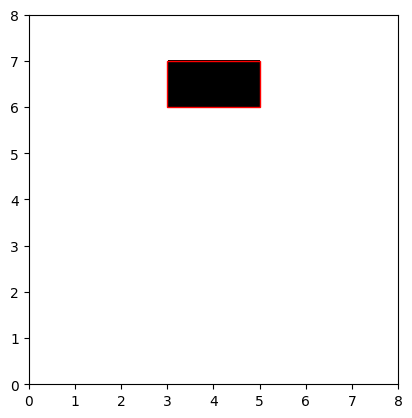

In [3]:
i = 0
plt.imshow(imgs[i], cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

We werken met een klassiek feedforward netwerk en niet met een convnet, dus we moeten elke image reshapen naar een vector:

In [4]:
# Reshape the images
X = imgs.reshape(num_imgs, -1)
X.shape

(50000, 64)

De outputs moeten we eveneens reshapen en bovendien gaan we de waarden herschalen:

In [5]:
# Normalize (x, y, w, h) by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IoU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, y.min(), y.max()

((50000, 4), 0.0, 0.75)

We splitsen de dataset in een training-, een validatie- en een testset (80% - 10% - 10%).

In [6]:
# Split training and validation.
n = int(0.1 * num_imgs)

train_X = X[:-2*n]
val_X = X[-2*n:-n]
test_X = X[-n:]
train_y = y[:-2*n]
val_y = y[-2*n:-n]
test_y = y[-n:]

test_imgs = imgs[-n:]
test_bboxes = bboxes[-n:]

We zijn klaar om het model te definiëren. We definiëren 2 `Dense` layers, waarvan de laatste de output is en dus 4 units moeten hebben. Tussen de twee lagen voegen we een `Dropout` layer.

In [7]:
# Build the model.
from tensorflow import keras
from keras import layers

model = keras.Sequential(name="Object_detection")
model.add(layers.Input(shape=(X.shape[-1], )))
model.add(layers.Dense(200, activation="relu", name="Dense"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(y.shape[-1], name="Output"))

model.summary()

Model: "Object_detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense (Dense)               (None, 200)               13000     
                                                                 
 Dropout (Dropout)           (None, 200)               0         
                                                                 
 Output (Dense)              (None, 4)                 804       
                                                                 
Total params: 13804 (53.92 KB)
Trainable params: 13804 (53.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We compileren het model en gebruiken RMSprop als optimizer. Omdat het een regressieprobleem is, gebruiken we de MSE als lossfunctie.

In [8]:
# Compile model.
model.compile("rmsprop", "mse")

We zijn klaar om het model te trainen. We doen dat gedurende 20 epochs.

In [9]:
# Train.
history = model.fit(train_X, train_y, epochs=20, validation_data=(val_X, val_y));

Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 3.5224e-04
Epoch 2/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 1.6630e-04
Epoch 3/20
1250/1250 [==============================] - 2s 2ms/step - loss: 9.3797e-04 - val_loss: 1.0801e-04
Epoch 4/20
1250/1250 [==============================] - 2s 2ms/step - loss: 8.3423e-04 - val_loss: 1.1106e-04
Epoch 5/20
1250/1250 [==============================] - 2s 2ms/step - loss: 7.6817e-04 - val_loss: 8.1729e-05
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 7.3373e-04 - val_loss: 7.0391e-05
Epoch 7/20
1250/1250 [==============================] - 3s 3ms/step - loss: 7.0088e-04 - val_loss: 5.6799e-05
Epoch 8/20
1250/1250 [==============================] - 2s 2ms/step - loss: 6.7753e-04 - val_loss: 5.4207e-05
Epoch 9/20
1250/1250 [==============================] - 3s 2ms/step - loss: 6.6228e-04 - val_loss: 5.0656e-05
Epoch 10/20
1250/1

Loss van zowel training- als validatieset zijn zeer laag, dus dat ziet er goed uit:

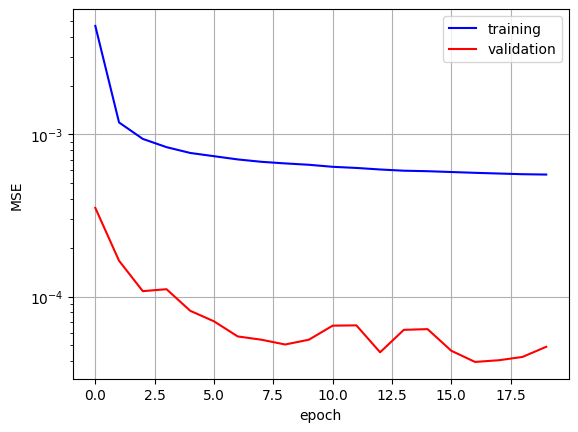

In [12]:
plt.semilogy(history.history['loss'], 'b-', label="training");
plt.semilogy(history.history['val_loss'], 'r-', label="validation");
plt.grid();
plt.xlabel('epoch');
plt.ylabel('MSE');
plt.legend();

Zowel loss van training en validatie zijn nog aan het dalen, maar de loss is al zeer klein, dus we houden het hier bij dit model. Wat geeft de finale evaluatie adhv de testset?

In [13]:
model.evaluate(test_X, test_y)

157/157 [==============================] - 0s 2ms/step - loss: 4.9968e-05


4.996807547286153e-05

De MSE van de testset is even laag, dus dit is ok.

In [14]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

157/157 [==============================] - 0s 1ms/step


(5000, 1, 4)

Een functie om de IoU te berekenen:

In [15]:
def IoU(bbox1, bbox2):
    '''Calculate Intersection over Union IoU between two bounding boxes bbox1 and bbox2
       where each bounding box is characterized by [x, y, w, h]
       with (x, y) the coordinate of the left lower corner,
       w the width, and h the height of the box'''

    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

Laten we eens enkele images met de voorspelde bounding box en de IoU plotten:

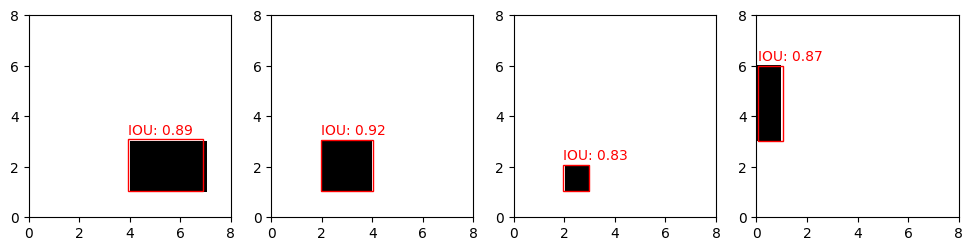

In [16]:
# Show a few images and predicted bounding boxes from the test dataset.
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i], cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IoU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')


Tot slot berekenen we de gemiddelde IoU van de testset:

In [17]:
# Calculate the mean IoU (overlap) between the predicted and expected bounding boxes on the test dataset.
np.mean([IoU(pred_bbox, test_bbox) for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4))])

0.8774910425571987

De gemiddelde IoU is dus meer dan 85%!

## Nu ook met classificatie...

We creëren nu een dataset waarin de rechthoeken ofwel wit ofwel grijs zijn. D.w.z. dat we naast de bounding box ook de klasse willen voorspellen, nl. wit of grijs!

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [19]:
# Create images with random rectangles and bounding boxes.

num_imgs = 50_000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

imgs = np.zeros((num_imgs, img_size, img_size))  # input (set background to 0)
bboxes = np.zeros((num_imgs, num_objects, 4))  # output
labels = np.zeros(num_imgs, dtype=int)

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, y:y+h, x:x+w] = 1.0 if (i_img % 2) else 0.5  # set rectangle to 1 or 0.5
        if i_img % 2:
            labels[i_img] = 1
        bboxes[i_img, i_object] = [x, y, w, h]

imgs.shape, bboxes.shape, labels.shape

((50000, 8, 8), (50000, 1, 4), (50000,))

Ter illustratie plotten we de eerste twee voorbeelden in de dataset:

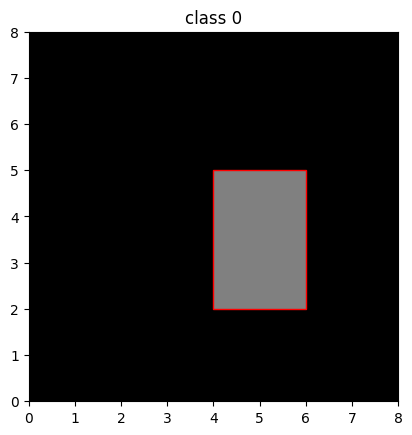

In [20]:
i = 0
plt.imshow(imgs[i], cmap='gray', vmin=0, vmax=1, origin='lower', extent=[0, img_size, 0, img_size])
plt.title("class " + str(labels[i]));
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

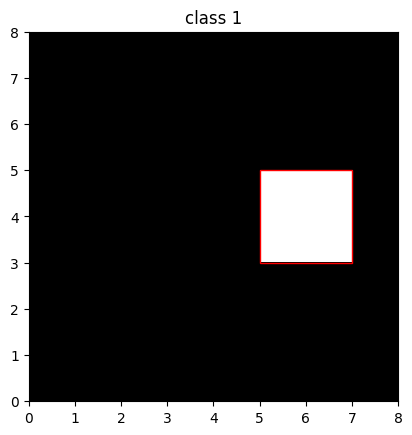

In [21]:
i = 1
plt.imshow(imgs[i], cmap='gray', vmin=0, vmax=1, origin='lower', extent=[0, img_size, 0, img_size])
plt.title("class " + str(labels[i]));
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

We werken opnieuw met een klassiek feedforward netwerk en niet met een convnet, dus we moeten elke image reshapen naar een vector:

In [22]:
# Reshape the images
X = imgs.reshape(num_imgs, -1)
X.shape

(50000, 64)

De bounding box outputs moeten we eveneens reshapen en bovendien gaan we de waarden herschalen:

In [23]:
# Normalize (x, y, w, h) by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IoU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, y.min(), y.max()

((50000, 4), 0.0, 0.75)

De tweede output met labels is ok en hoeft net getransformeerd te worden:

In [24]:
labels.shape

(50000,)

We splitsen de dataset opnieuw op in een training-, een validatie- en een testset (80% - 10% - 10%).

In [25]:
# Split training and validation.
n = int(0.1 * num_imgs)

train_X = X[:-2*n]
val_X = X[-2*n:-n]
test_X = X[-n:]
train_y = y[:-2*n]
val_y = y[-2*n:-n]
test_y = y[-n:]
train_labels = labels[:-2*n]
val_labels = labels[-2*n:-n]
test_labels = labels[-n:]

test_imgs = imgs[-n:]
test_bboxes = bboxes[-n:]
test_labels = labels[-n:]

We zijn klaar om het model te definiëren. Maar hoe gaan we dat doen? We hebben nu twee soorten output: de bounding box en de klasse. Het ene moet opgelost worden via regressie, het andere is een classificatieprobleem. Hoe ga je dit probleem oplossen?

Tip: check hfst 7 uit het handboek! Daar hebben we een voorbeeld gezien van een multi-input multi-output model.

In [26]:
# Build the model using the functional API as we need two output layers:
# 1. a "regression" output layer for the bounding boxes
# 2. a "classification" output layer for the classes

from tensorflow import keras
from keras import layers

inputs = layers.Input(shape=(X.shape[-1], ), name="Input")
x = layers.Dense(200, activation='relu', name="Dense1")(inputs)
x = layers.Dropout(0.2, name="Dropout1")(x)
x = layers.Dense(50, activation='relu', name="Dense2")(x)
x = layers.Dropout(0.1, name="Dropout2")(x)
bbox_output = layers.Dense(y.shape[-1], name="BBox")(x)
class_output = layers.Dense(1, activation="sigmoid", name="Class")(x)
model = keras.Model(inputs, [bbox_output, class_output], name="Object_detection")

model.summary()

Model: "Object_detection"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 Dense1 (Dense)              (None, 200)                  13000     ['Input[0][0]']               
                                                                                                  
 Dropout1 (Dropout)          (None, 200)                  0         ['Dense1[0][0]']              
                                                                                                  
 Dense2 (Dense)              (None, 50)                   10050     ['Dropout1[0][0]']            
                                                                                   

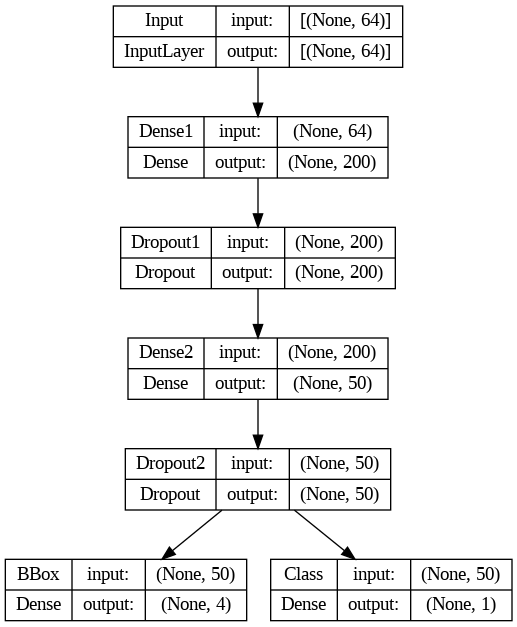

In [27]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

In [28]:
# Compile model.
# We need two loss functions and two metrics. We use dicts!
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=5e-4),
              loss=dict(BBox="mse", Class="binary_crossentropy"),
              metrics=dict(BBox="mae", Class="accuracy"))

In [29]:
# Train model.
# Outputs are passed as lists (in the right order!)
history = model.fit(train_X, [train_y, train_labels],
                    epochs=20,
                    validation_data=(val_X, [val_y, val_labels]),
                    batch_size=128);

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 0.4942 - BBox_loss: 0.0286 - Class_loss: 0.4656 - BBox_mae: 0.1308 - Class_accuracy: 0.7879 - val_loss: 0.2195 - val_BBox_loss: 0.0107 - val_Class_loss: 0.2088 - val_BBox_mae: 0.0817 - val_Class_accuracy: 0.9688
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 0.1281 - BBox_loss: 0.0227 - Class_loss: 0.1054 - BBox_mae: 0.1182 - Class_accuracy: 0.9845 - val_loss: 0.0342 - val_BBox_loss: 0.0082 - val_Class_loss: 0.0260 - val_BBox_mae: 0.0705 - val_Class_accuracy: 1.0000
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.0366 - BBox_loss: 0.0158 - Class_loss: 0.0208 - BBox_mae: 0.0984 - Class_accuracy: 0.9991 - val_loss: 0.0106 - val_BBox_loss: 0.0065 - val_Class_loss: 0.0041 - val_BBox_mae: 0.0622 - val_Class_accuracy: 1.0000
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.0179 - BBox_loss: 0.0113 - Class_loss: 0.0066 - BBox_mae: 0.0834 -

In [30]:
# Checking the history keys:
history.history.keys()

dict_keys(['loss', 'BBox_loss', 'Class_loss', 'BBox_mae', 'Class_accuracy', 'val_loss', 'val_BBox_loss', 'val_Class_loss', 'val_BBox_mae', 'val_Class_accuracy'])

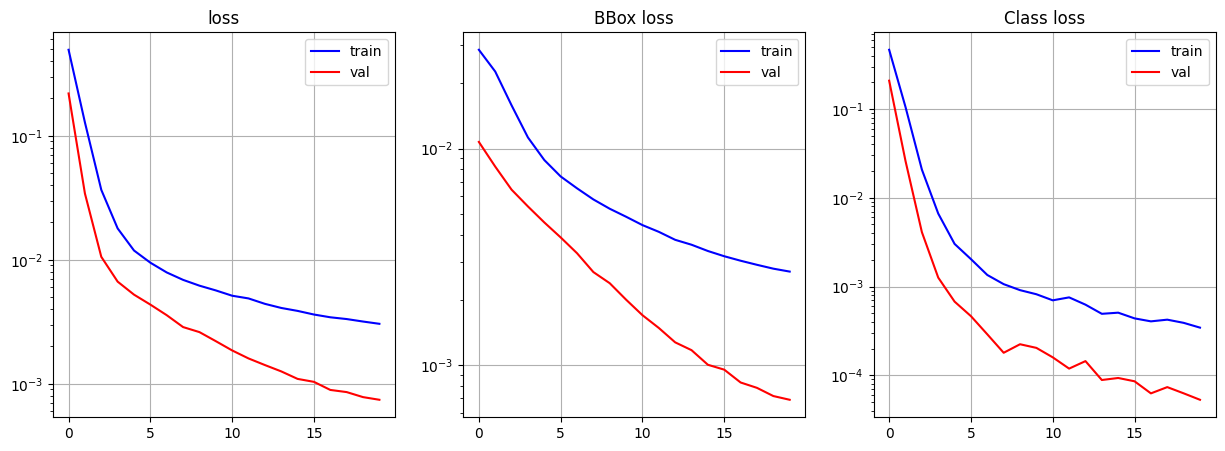

In [31]:
# Plotting losses.
plt.figure(figsize=(15, 5))
for i, loss in enumerate(["", "BBox", "Class"]):
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history[loss + ("" if loss == "" else "_") + 'loss'], 'b-');
    plt.semilogy(history.history['val_' + loss + ("" if loss == "" else "_") + 'loss'], 'r-');
    plt.grid();
    plt.title(loss + ("" if loss == "" else " ") +  'loss');
    plt.legend(['train', 'val']);

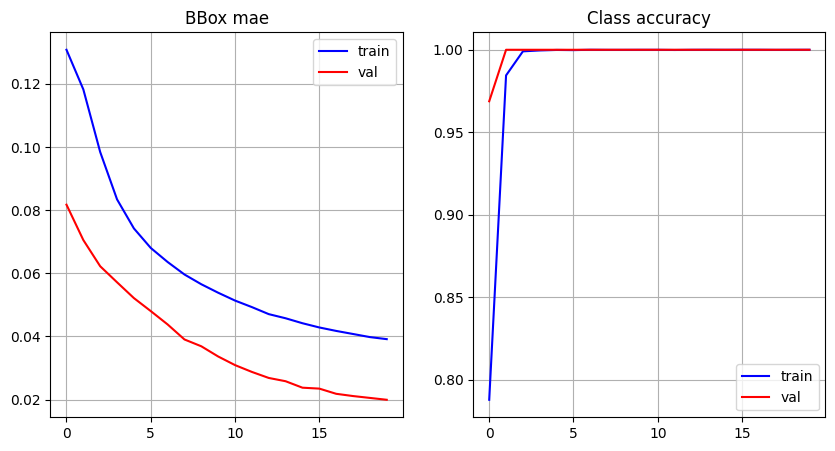

In [32]:
# Plotting metrics.
plt.figure(figsize=(10, 5))
for i, (output, metric) in enumerate(dict(BBox='mae', Class='accuracy').items()):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[output + "_" + metric], 'b-');
    plt.plot(history.history['val_' + output + "_" + metric], 'r-');
    plt.grid();
    plt.title(output + " " + metric);
    plt.legend(['train', 'val']);

In [33]:
# Evaluate model using the test set.
model.evaluate(test_X, [test_y, test_labels])

157/157 [==============================] - 0s 2ms/step - loss: 7.3074e-04 - BBox_loss: 6.7750e-04 - Class_loss: 5.3238e-05 - BBox_mae: 0.0199 - Class_accuracy: 1.0000


[0.0007307399646379054,
 0.0006775016081519425,
 5.323841469362378e-05,
 0.019850680604577065,
 1.0]

In [34]:
# Predict bounding boxes and labels on the test images.
pred_y, pred_labels = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

157/157 [==============================] - 0s 2ms/step


(5000, 1, 4)

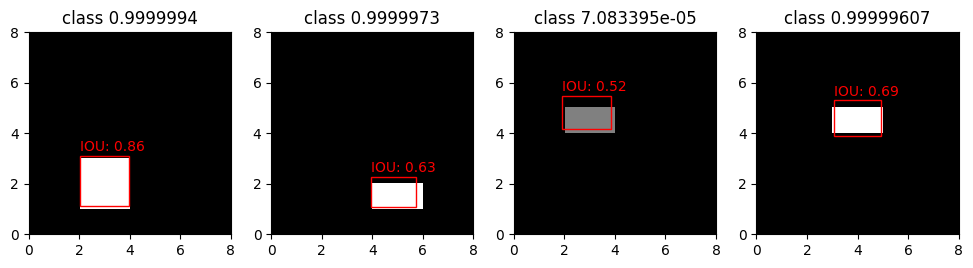

In [35]:
# Show a few images and predicted bounding boxes and class probabilities from the test dataset.
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i], cmap='gray', vmin=0, vmax=1, origin='lower', extent=[0, img_size, 0, img_size])
    plt.title("class " + str(pred_labels[i][0]));
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IoU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')


In [39]:
# Calculate the mean IoU (overlap) between the predicted and expected bounding boxes on the test dataset.
mIoU = np.mean([IoU(pred_bbox, test_bbox) for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4))])
print(f'mean IoU is {mIoU * 100:.1f} %')

mean IoU is 67.0 %


## Verdere stappen

De blog gaat nog enkele stappen verder door meerdere rechthoeken toe te voegen aan de images, meerdere vormen, en tenslotte ook meerdere kleuren. Check zeker eens de notebooks in de GitHub repo van de auteur om te zien hoe die dat concreet heeft geïmplementeerd: https://github.com/jrieke/shape-detection.

Aangezien de repo al enkele jaren oud is, wordt een verouderde versie van Keras gebruikt in de notebooks. Een goeie oefening is om die notebooks te updaten naar de recentste versie van Keras!

---
## Bronnen

- https://en.wikipedia.org/wiki/Object_detection
- https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
- https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
- https://datascience-enthusiast.com/DL/Autonomous_driving_Car_detection.html
- https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491
- Chollet, F. (2021) Deep Learning with Python, Second Edition, Manning, Shelter Island, NY.


---